In [0]:
from google.colab import files
from google.colab import drive
import requests
from io import BytesIO
import zipfile
import cv2
from PIL import Image
import requests
from io import BytesIO
import glob, os, re
import time
import shutil, sys 
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Activation, Input
from keras import callbacks
from keras import applications
from keras.applications import VGG16
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


In [0]:
def preprocessImages(listImages):
  nbImages = len(listImages)
  shape = (nbImages,150,150,3)
  imagesArr = np.zeros(shape=shape)
  urlsLoaded = []
  urlsError = []
  i=0
  nbErrors = 0
  for url in listImages:
    response = requests.get(url)
    try:
      im = Image.open(BytesIO(response.content)) #open image with url
      im = im.resize((150,150)) # resize image
      imagesArr[i] = np.array(im) #save image as a np array
      urlsLoaded.append(url) #save its url
      i = i+1
    except:
      nbErrors = nbErrors+1 #count loading errors
      urlsError.append(url) #save url which can't be loaded
  
  print(nbImages-nbErrors, '/', nbImages,' images loaded')
  
  numpyImages = np.zeros(shape=(len(imagesArr)-nbErrors,150,150,3)) #remove errors
  for i in range(0,len(numpyImages)):
    numpyImages[i] = imagesArr[i]
  numpyImages = numpyImages.astype('float32') #rescale
  numpyImages /= 255.
  
  return numpyImages,urlsLoaded #return array of image arrays ; urlLoaded

In [0]:
def cnnPreprocess (listImages):
  print('preprocessing CNN...')
  numpyImages = preprocessImages(listImages)[0]
  urlsLoaded = preprocessImages(listImages)[1]
  
  model = models.load_model('/content/drive/My Drive/Data Chimera/Models/unfrozen_model_InOutTrash.h5') #CHANGE THE PATH OF THE MODEL
  predictions = model.predict(numpyImages)
  predicted_classes = np.argmax(predictions, axis=1)
  
  indexOutdoor =[]
  for i in range(0,len(predicted_classes)):
    if predicted_classes[i]==1:
      indexOutdoor.append(i)
  
  outdoorUrls = []
    
  for index in indexOutdoor:
    outdoorUrls.append(urlsLoaded[index])
    
  return outdoorUrls #return outdoor images urls

In [0]:
def displayResults (listImages, listApart, listHouse):
  errA = 0
  errH = 0
  urlErrA = []
  urlErrH = []
  
  if (listApart !=[]):
    print('images predicted as apartments : \n')
    for url in listApart:
      response = requests.get(url)
      try:
        im = Image.open(BytesIO(response.content)) #open image with url
        plt.close()
        plt.imshow(np.asarray(im))
        plt.show()
        time.sleep(0.01)
      except:
        errA = errA+1 #count loading errors
        print('rentre dans la bocle erreur apart ??')
        urlErrA.append(url) #save url which can't be loaded
    print(len(listApart)-errA, '/', len(listApart),' aparts loaded \n')
  
  if (listHouse !=[]):
    print('images predicted as houses : \n')
    for url in listHouse:
      response = requests.get(url)
      try:
        im = Image.open(BytesIO(response.content)) #open image with url
        plt.close()
        plt.imshow(np.asarray(im))
        plt.show()
        time.sleep(0.01)
      except:
        errH = errH+1 #count loading errors
        print('rentre dans la bocle erreur house ??')
        urlErrH.append(url) #save url which can't be loaded
    print(len(listHouse)-errH, '/', len(listHouse),' houses loaded \n')
  
  print(len(listImages) - (len(listApart)+len(listHouse)), 'images predicted as indoors/trash \n')
  

In [0]:
def classifHouseApart(listImages):
  houseUrls =[]
  apartUrls =[]
  outdoorUrls = cnnPreprocess (listImages)
  if outdoorUrls==[]:
    print('No outdoor pictures for that item')
    return apartUrls,houseUrls
  else:
    print('classification CNN...')
    numpyImages = preprocessImages(outdoorUrls)[0]
    urlsLoaded = preprocessImages(outdoorUrls)[1]

    model = models.load_model('/content/drive/My Drive/Data Chimera/Models/unfrozen_model.h5') #CHANGE THE PATH OF THE MODEL
    predictions = model.predict(numpyImages)
    predicted_classes = np.argmax(predictions, axis=1)

    #separate into folders house/apart images
    indexHouse =[]
    indexApart =[]

    #get index of all the 1 class images
    for i in range(0,len(predicted_classes)):
      if predicted_classes[i]==1:
        indexHouse.append(i)
      else:
        indexApart.append(i)

    for index in indexHouse:
      houseUrls.append(urlsLoaded[index])

    for index in indexApart:
      apartUrls.append(urlsLoaded[index])
      
    if (houseUrls == []) and (apartUrls == []):
      print("No apart or house pictures for that item")
      return apartUrls,houseUrls
    else:
      print('found ',len(apartUrls),' apartment images and ',len(houseUrls),' house images')
      displayResults(listImages, apartUrls, houseUrls)
      return apartUrls,houseUrls #return apart and house images urls
  

In [0]:
####################  EXAMPLE  ################

In [0]:
listUrlsImages = ['https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_1.jpg?cache=20180406132729',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_2.jpg?cache=20180406132729',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_3.jpg?cache=20180406132729',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_4.jpg?cache=20180406132729',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_5.jpg?cache=20180406132729',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_6.jpg?cache=20180406132729',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_7.jpg?cache=20180406132730',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_8.jpg?cache=20180406132730',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_9.jpg?cache=20180406132730',
 'https://static.immoweb.be/photos/0/7/4/7/4/6/4/9/7474649_A.jpg?cache=20180406132730']

preprocessing CNN...
10 / 10  images loaded
10 / 10  images loaded
classification CNN...
10 / 10  images loaded
10 / 10  images loaded
found  6  apartment images and  4  house images
images predicted as apartments : 



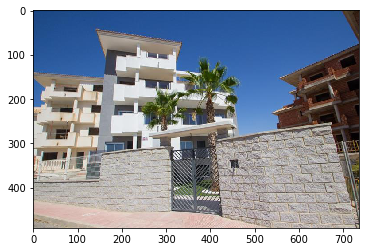

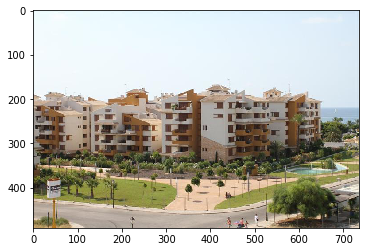

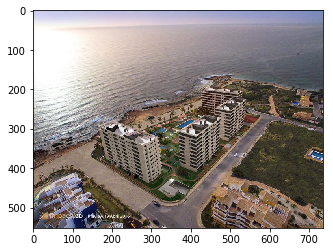

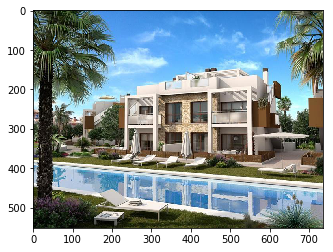

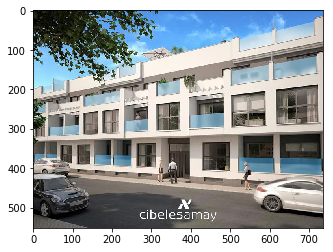

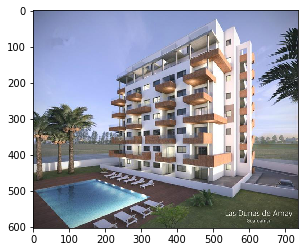

6 / 6  aparts loaded 

images predicted as houses : 



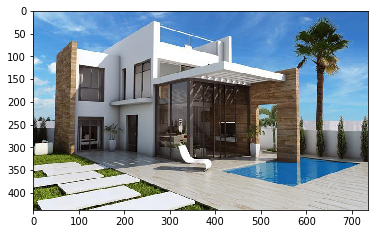

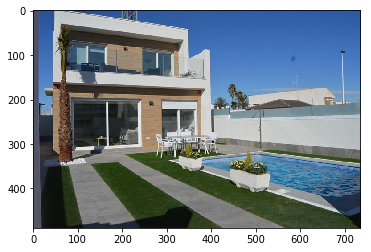

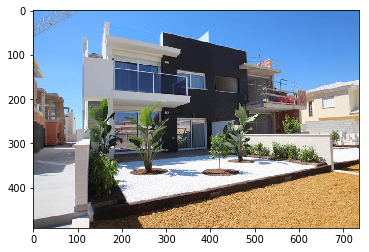

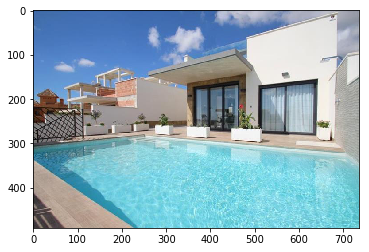

4 / 4  houses loaded 

0 images predicted as indoors/trash 



In [0]:
apart = []
house = []

apart,house = classifHouseApart(listUrlsImages)